In [1]:
#William Zabet
#CSCI 6511 - AI
#Project2: CSP Graph Coloring

#Importing libraries required
import re
import networkx as nx
from copy import deepcopy
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
#Code for the CSP is all in one function that takes a text file as input
def cspALG(textFile):
    # opens the textfile and reads it
    text = open(textFile, "r")
    #initializing variable to find the ammout of colors used
    n = 0
    #initializing a dictionary of the nodes as the key and nodes that share an edge as the values
    edgesMap = {}
    #initializing an empty list for the colors that will be used
    colors = []
    #initializing an empty list of all the vertices in the graph
    vertices = []
    #a list of colors that can be used in the function, depending on how many colors the text file wants to use
    colorList = ["red", "green", "blue", "yellow", "pink", "brown", "gray", "purple", "orange",
                 "cyan", "olive", "navy", "lavender"]

    #for loop to read each line w/in the txt file
    for line in text:
        #skips over lines that start w/ a #
        if not line.startswith("#"):
            #if the line starts w/ colors:
            if line.startswith("colors"):
                #regex search to find the number of number of colors to use
                #storing the number into two varibales because the code wouldnt run when the same var was used twice
                #converting string to int
                n = int(re.findall("\d+",line)[0])
            else:
                #for all other lines in the txt file:
                #the line gets split by the comma to have two string values
                line = line.split(",")
                
                #vertex 1 and vertex2 are stored for each line and then converted into an INT    
                v1 = int(line[0])
                v2 = int(line[1])
                
                #if the starting vertex isnt in the dictionary then it gets added along w the key
                if v1 not in edgesMap.keys():
                    edgesMap[v1] = [v2]
                else:
                    #if already in the dict, then the key gets appended to the value
                    edgesMap[v1].append(v2)
                
                #this does the same thing but stores the edges the other way around since this is an undirected graph
                if v2 not in edgesMap.keys():
                    edgesMap[v2] = [v1]
                else:
                    edgesMap[v2].append(v1)            
    text.close()
    
    #function to get the colors that will be used in the plot based off the value of n1
    def getColors():
        colors = []
        counter = 0
        while counter < n:
            colors.append(colorList[counter])
            counter+=1
        return colors
    
    #storing all the nodes in the graph into a list
    for vertex in edgesMap.items():
        vertices.append(vertex[0])
    
    #storing all the edges into a list of strings
    edges_listStr = []
    for x in edgesMap.keys():
        for y in edgesMap[x]:
            if x != y:
                edges_listStr.append((str(x),str(y)))

    #storing all the vertices w/in the graph into a list of strings
    vertices_listStr = []
    for i in vertices:
        vertices_listStr.append(str(i))

    #function checks if the current solution is comlete by seeing if it has assigned colors to each node
    def completeness(solution, nodes):
        return True if len(solution) == len(nodes) else False

    #function checks if the solution is consistent w/ the constraints and has no conflicts
    def consistency(node, color, assignment, constraints):
        if assignment is None:
            return False
        for v in constraints:
            if v in assignment:
                if color is assignment[v]:
                    return False
        return True
    
    #function to perform a DFS. assignment var is an empty dictionary and if a color cant be assigned then
    # the function backtracks to the previous assignment and tries again until a solution is found
    def backtrack(assignment, cspDict, heuristics):
        currNode, order_domain_colors, inference = heuristics
        if completeness(assignment, cspDict[0]):
            return True, assignment
        node = currNode(assignment, cspDict)
        for color in order_domain_colors(node, assignment, cspDict):
            if consistency(node, color, assignment, cspDict[2][node]):
                assignment[node], cspInter = color, deepcopy(cspDict)
                if inference(cspDict, node, color, assignment):
                    result, assignment = backtrack(deepcopy(assignment), cspDict, heuristics)
                    if result:
                        return True, assignment
                del assignment[node]
                cspDict = cspInter
        return False, assignment

    #driver code for the backtrack function
    def backtrackMain(cspDict, heuristics):
        solution = dict()
        return backtrack(solution, cspDict, heuristics)
    
    #stores the edges into an adjacency list
    def adjacencies(nodes, edges):
        adjacenciesList = dict()
        for node in nodes:
            adjacenciesInter = set()
            [adjacenciesInter.add(x) for x, y in edges if x != node and y == node]
            [adjacenciesInter.add(y) for x, y in edges if y != node and x == node]
            adjacenciesList[node] = adjacenciesInter
        return adjacenciesList

    #functions are written later on but are declared initially in order to be recignized by the functions that come
    # before them
    def MRV():
        pass
    def LCV():
        pass
    def forwardChecking():
        pass
    
    #colors the graph with the nodes an edges
    def cspGraph(graph, colors=getColors(), heuristics=(MRV, LCV, forwardChecking)):
        nodes = graph[0]
        domains = dict([(x, colors) for x in nodes])
        constraints = adjacencies(graph[0], graph[1])
        result, solution = backtrackMain((nodes, domains, constraints), heuristics)
        if not result:
            print("No Solution")
        else:
            return solution
        
    #plots the solution based off of the colors selected
    def cspPlot(graph, colors, pos=None):
        if colors is None:
            return
        fig = plt.figure()
        G = nx.Graph()
        if pos is None:
            pos = nx.spring_layout(G)      
        G.add_nodes_from(graph[0])
        G.add_edges_from(graph[1])
        node_colors = [colors[v] for v in G.nodes()]
        nx.draw(G, node_color=node_colors, node_size=450,  with_labels=True)
        plt.show()

    # a forward checking function to delete all color assignments from the domain of neighbors
    def forwardChecking(cspDict, node, color, assignment):
        unassigned_neighbors = [v for v in cspDict[2][node] if v not in assignment]
        for neighbor in unassigned_neighbors:
            if color in cspDict[1][neighbor]:
                cspDict[1][neighbor] = [v for v in cspDict[1][neighbor] if v is not color]
            if len(cspDict[1][neighbor]) == 0:
                return False
        return True

    #a minimum remaining value heuristic function. picks a variable thats most likely to fail first
    def MRV(solution, cspDict):
        unassigned_nodes = [x for x in cspDict[0] if x not in solution]
        node_domain_count = [(x, len(cspDict[1][x])) for x in unassigned_nodes]
        nodes = sorted(node_domain_count, key=itemgetter(1))
        return nodes[0][0]

    # a least constraining value function. selects the color that is most common in the neighbors
    def LCV(node, assignment, cspDict):
        neighbors = cspDict[2][node]
        colorCount = []
        for color in cspDict[1][node]:
            count = 0
            for neighbor in neighbors:
                if color in cspDict[1][neighbor]:
                    count = count + 1
            colorCount.append((color, count))
        counted = sorted(colorCount, key=itemgetter(1), reverse=True)
        for color, count in counted:
            yield color

    #a function to store the nodes and edges so that it can be provided to the solution variable
    def cspMap():
        nodes = vertices_listStr
        edges = edges_listStr
        return (nodes, edges)

    #solution with the nodes and edges and with what heuristics we want to use
    # My removes values from unassigned variables and also propagates those changes forward. 
    # Therefore, it uses both Forward Checking and AC3 along w/ the heuristics to solve the CSP.
    solution = cspGraph(cspMap(), heuristics=(MRV, LCV, forwardChecking))
    #prints the color assignments
    print(solution)
    #plots the graph
    cspPlot(cspMap(), solution)

{'0': 'red', '1': 'green', '2': 'green', '3': 'green', '5': 'blue', '4': 'red', '7': 'yellow', '6': 'green', '8': 'blue', '9': 'red', '31': 'yellow', '12': 'blue', '19': 'red', '10': 'red', '11': 'green', '13': 'green', '14': 'blue', '15': 'yellow', '16': 'yellow', '17': 'blue', '20': 'yellow', '18': 'red', '27': 'green', '21': 'red', '22': 'green', '23': 'green', '24': 'blue', '25': 'yellow', '26': 'green', '28': 'blue', '30': 'red', '29': 'red', '32': 'yellow', '33': 'green', '34': 'red', '35': 'blue', '41': 'yellow', '37': 'green', '40': 'blue', '36': 'blue', '38': 'red', '39': 'red', '42': 'blue', '43': 'green', '44': 'yellow', '45': 'yellow', '46': 'green', '47': 'yellow', '52': 'red', '53': 'blue', '48': 'yellow', '49': 'blue', '50': 'red', '51': 'red', '54': 'red', '56': 'blue', '59': 'yellow', '58': 'blue', '57': 'green', '55': 'blue'}


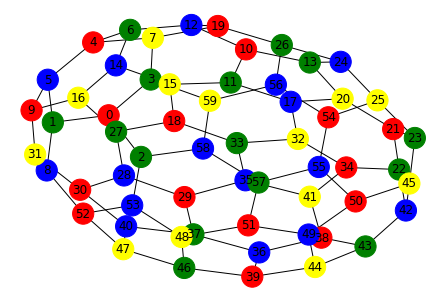

In [13]:
cspALG("g1.txt")

{'1': 'red', '2': 'green', '3': 'blue', '4': 'blue', '5': 'green', '6': 'yellow', '7': 'red'}


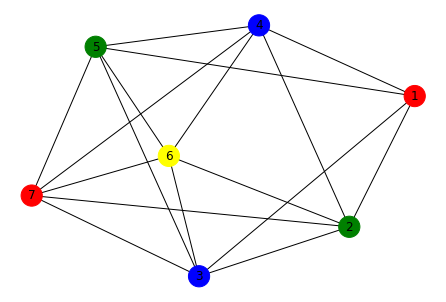

In [14]:
cspALG("g2.txt")

{'0': 'red', '1': 'green', '2': 'blue', '3': 'yellow', '4': 'green', '5': 'blue', '6': 'yellow', '8': 'yellow', '7': 'red', '9': 'blue', '10': 'red', '11': 'blue', '12': 'green', '14': 'red', '13': 'yellow', '15': 'green', '16': 'red', '17': 'green', '18': 'yellow', '19': 'blue', '20': 'green', '21': 'blue', '22': 'yellow'}


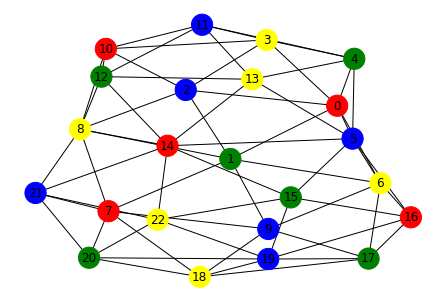

In [5]:
cspALG("g3.txt")

{'0': 'red', '1': 'green', '2': 'blue', '4': 'yellow', '3': 'green', '5': 'blue', '6': 'yellow', '13': 'red', '14': 'yellow', '7': 'red', '8': 'green', '9': 'blue', '10': 'green', '11': 'blue', '12': 'yellow'}


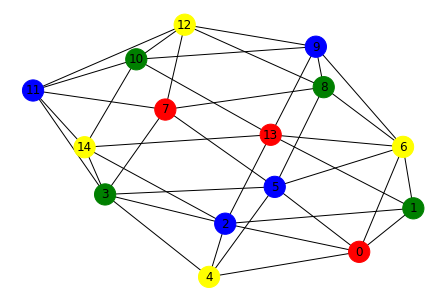

In [6]:
cspALG("g4.txt")

{'0': 'red', '1': 'green', '3': 'blue', '4': 'blue', '2': 'yellow', '5': 'green', '6': 'yellow', '7': 'red', '9': 'red', '15': 'blue', '16': 'green', '8': 'green', '10': 'blue', '11': 'yellow', '12': 'blue', '13': 'red', '14': 'green'}


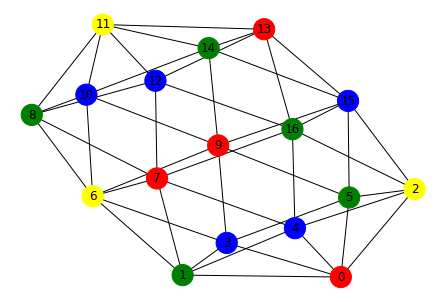

In [7]:
cspALG("g5.txt")

In [8]:
#This txt file was the text file in a zip folder provided by the professor on his GitHub.
#It is too large to run on my hardware so it is commented out. 
#cspALG("g6.txt")